In [1]:
import sys 
from pathlib import Path
import tensorflow as tf
import pandas as pd
import numpy as np 
import keras

module_path = str(Path.cwd().parents[0]/'Encoder')
if module_path not in sys.path:
    sys.path.append(module_path)

from Encoder import Encoder

file_path = "C:\\Users\\nvanb\\Documents\\Master\\1_Masterstage\\master_stage\\Float_data\\Float_data_10000_events_at_10.csv"

In [2]:
def train_val_test_split(df):
    # np.split() to split the dataset
    # train_znorm.sample(frac=1, random_state=42) to shuffle the dataset random
    # [int(.6*len(train_znorm)),int(.8*len(train_znorm))] first split after 60% of the data. second split after 80%
    # 60% train set - 20% validation set - 20% test set
    df_train, df_validate, df_test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)),int(.8*len(df))])
    return df_train, df_validate, df_test

def clean_data(array): 
    """Takes an 2 dimensional array with np.isnan() values, 
    cuts the np.isnan() values out and applies a pre-padding. It
    returns a 2 dimensional array where all rows have the same length"""
    clean_list = []
    for row in range (0, len(array)):
        temp_list = np.array([x for x in array[row] if not np.isnan(x)])
        pad_width = len(array[0])-len(temp_list)
        pad_array = np.zeros(pad_width)
        padded_list = np.concatenate((pad_array, temp_list))
        clean_list.append(padded_list)  
    return clean_list

def define_targets_and_features(df): 
    """Function defines the features and targets of a dataframe,
    The targets are in the last column of the dataframe; the features are in the other columns"""
    
    features, targets = df.keys()[0:-1], df.keys()[1:]
    return features, targets

In [3]:
df_data = pd.DataFrame(pd.read_csv(file_path))

# Make train, validation and test split
df_train, df_validate, df_test = train_val_test_split(df_data)

# Convert df to array, remove nans and apply pre-padding
train_set = df_train.to_numpy()
validate_set = df_validate.to_numpy()

# Store test to .csv file
df_test.to_csv("C:\\Users\\nvanb\\Documents\\Master\\1_Masterstage\\master_stage\\Float_data\\var_length_testdata.csv")

train_set = clean_data(train_set)
validate_set = clean_data(validate_set)

train_set = pd.DataFrame(train_set).astype(int)
validate_set = pd.DataFrame(validate_set).astype(int)

# Define targets and features
features, targets = define_targets_and_features(train_set)

# Store as a tensorflow tensor to make it a valid input for the encoder model
train_features = train_set[features]
train_targets = train_set[targets]
validate_features = validate_set[features]
validate_targets = validate_set[targets]

In [4]:
d_model = int(512/4)
d_ff = 2048
batch_size = 64
h = 8 
n = 6
d_k = int(d_model/h)
d_v = int(d_model/h)
rate = 0.1

n_events = df_data.shape[0]
vocab_size = int(np.max(np.max(df_data), axis=0)+1) # add one because we include 0

padding_mask = None
seq_length = len(df_data.columns)+vocab_size
print(vocab_size)
print(seq_length)
print(d_k)


28
37
16


c:\Users\nvanb\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [5]:
# Define the loss function and optimizer
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2), keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2)]

In [6]:
encoder_model = Encoder(batch_size, seq_length, h, n, d_model, d_ff, d_k, d_v, rate, vocab_size, d_model, padding_mask, training=True)
encoder_model.build(input_shape=(n_events, seq_length))
encoder_model.summary()

Tensor("position_embedding_fixed_weights/add:0", shape=(10000, 37, 128), dtype=float32)
Tensor("layer_normalization_1/add:0", shape=(10000, 37, 128), dtype=float32)
Tensor("layer_normalization_3/add:0", shape=(10000, 37, 128), dtype=float32)
Tensor("layer_normalization_5/add:0", shape=(10000, 37, 128), dtype=float32)
Tensor("layer_normalization_7/add:0", shape=(10000, 37, 128), dtype=float32)
Tensor("layer_normalization_9/add:0", shape=(10000, 37, 128), dtype=float32)
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 position_embedding_fixed_we  multiple                 19968     
 ights (PositionEmbeddingFix                                     
 edWeights)                                                      
                                                                 
 encoder_layer (EncoderLayer  multiple                 0 (unused)
 )                                              

In [7]:
num_epochs = 5
encoder_model.compile(optimizer, loss=loss_function, metrics='accuracy')
history = encoder_model.fit(train_features, train_targets, batch_size=batch_size, epochs=num_epochs, validation_data=(validate_features, validate_targets), callbacks=callbacks)

encoder_model.save_weights("C:\\Users\\nvanb\\Documents\\Master\\1_Masterstage\\master_stage\\Float_data\\model_varlen.keras")

Epoch 1/5
Tensor("encoder/position_embedding_fixed_weights/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_1/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_3/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_5/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_7/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_9/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/position_embedding_fixed_weights/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_1/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_3/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_5/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_7/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_9/add:0", shape=(No

In [10]:
epoch_history = [_ for _ in range (0,num_epochs)]
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

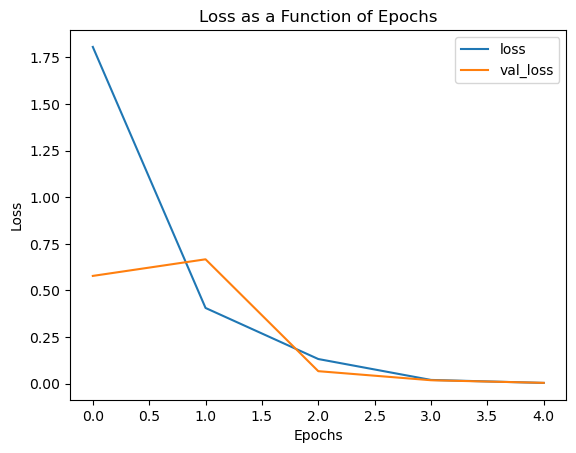

In [11]:
import matplotlib.pyplot as plt

plt.plot(epoch_history, loss_history, label='loss')
plt.plot(epoch_history, val_loss_history, label='val_loss')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()